In [1]:
import dexplor_utils
import prep_utils
import numpy as np
import pandas as pd
import train_utils
import keras
from scipy.stats import randint as sp_randint
%matplotlib inline

/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


#### load preprocessed data

In [2]:
train_df, y_train_df, test_df = dexplor_utils.load_preprocessed(
    csv_list=['./data/data1_1/x_train1.csv', './data/data1_1/y_train1.csv', './data/data1_1/x_test1.csv'])

In [3]:
train_df.shape, y_train_df.shape, test_df.shape

((10506, 31), (10506, 1), (116293, 31))

In [4]:
prep_utils.print_classes_ratio(y_train_df)

number of classes:2
classes ratios: 5.24% (551) negative samps, 94.76% (9955) positive samps


#### Scale features

In [5]:
x_train_scaled, x_test = prep_utils.scale_features(train_df, test_df)

#### Split, resample and augment (20% for selected features)

In [6]:
# train-val split, resample and augment minor class (train only)
x_train, x_val, y_train, y_val, state = prep_utils.train_val_data_split(
    x_train_scaled, y_train_df, 0.5, train_df.columns.tolist(), state=42, pprint=False)

after augment train dist - 
50.00%(6670) positive samples, 50.00%(6670) negative samples 


In [7]:
# also experimented with resample and augment minor class than train-val split
x_train, x_val, y_train, y_val, state = prep_utils.resample_augment_split(
    x_train_scaled, y_train_df, 0.4, train_df.columns.tolist(), state=42, pprint=False)

after augment train dist - 
50.00%(9955) positive samples, 50.00%(9955) negative samples 


In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape

((13339, 31), (13339,), (6571, 31), (6571,), (116293, 31))

#### Check dimentionality reduction

In [177]:
prep_utils = imp.reload(prep_utils)

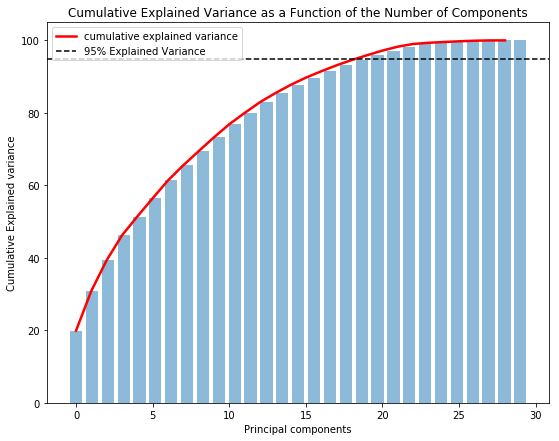

In [178]:
all_data = pd.concat([x_test, x_train])
pca = prep_utils.plot_pca(all_data)

#### Trained with/out trap feature

In [10]:
x_train = x_train.drop(['Trap'], axis=1)
x_test = x_test.drop(['Trap'], axis=1)

#### Decision Tree

In [187]:
x_train, x_val, y_train, y_val, state = prep_utils.train_val_data_split(
    x_train_scaled, y_train_df, 0.4, train_df.columns.tolist(), pprint=False)

random_state: 1231
after augment train dist - 
50.00%(6653) positive samples, 50.00%(6653) negative samples 


best auc: 0.7266, val_score: 0.7753, min_impurity_decrease:0.042


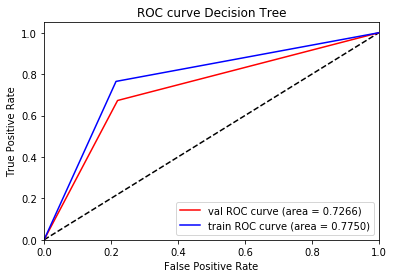

             precision    recall  f1-score   support

          0       0.98      0.78      0.87      3302
          1       0.13      0.67      0.22       165

avg / total       0.94      0.78      0.84      3467



In [188]:
min_imp_rng = [0.002, 0.042, 81]
clf_dt, pred_val_dt = train_utils.fit_dt(x_train, y_train, x_val, y_val, min_imp_rng)

train_utils.plot_roc(x_train, y_train, x_val, y_val, clf_dt, 'Decision Tree')

#### Random Forest

In [189]:
x_train, x_val, y_train, y_val, state = prep_utils.train_val_data_split(
    x_train_scaled, y_train_df, 0.4, train_df.columns.tolist(), pprint=False)

random_state: 1019
after augment train dist - 
50.00%(6683) positive samples, 50.00%(6683) negative samples 


best auc: 0.7780, val_score: 0.7540, min_impurity_decrease:0.042


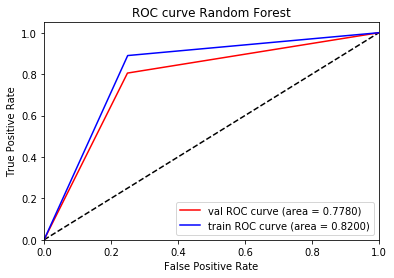

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      3272
          1       0.16      0.81      0.27       195

avg / total       0.94      0.75      0.82      3467



In [190]:
min_imp_rng = [0.002, 0.042, 81]
clf_rf, pred_val_rf = train_utils.fit_dt(x_train, y_train, x_val, y_val, min_imp_rng, clf_type='rf')

train_utils.plot_roc(x_train, y_train, x_val, y_val, clf_rf, 'Random Forest')

In [191]:
x_train, x_val, y_train, y_val, state = prep_utils.train_val_data_split(
    x_train_scaled, y_train_df, 0.4, train_df.columns.tolist(), pprint=False)

random_state: 1225
after augment train dist - 
50.00%(6680) positive samples, 50.00%(6680) negative samples 


best auc: 0.7589, val_score: 0.7020, min_impurity_decrease:0.042


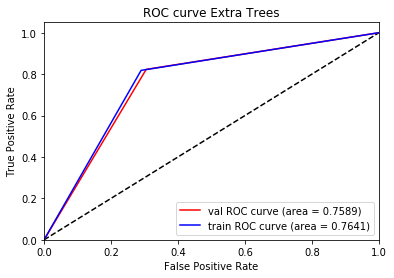

             precision    recall  f1-score   support

          0       0.99      0.69      0.82      3275
          1       0.14      0.82      0.23       192

avg / total       0.94      0.70      0.78      3467



In [192]:
min_imp_rng = [0.002, 0.042, 81]
clf_et, pred_val_et = train_utils.fit_dt(x_train, y_train, x_val, y_val, min_imp_rng, clf_type='et')

train_utils.plot_roc(x_train, y_train, x_val, y_val, clf_et, 'Extra Trees')

#### Train a neural net

In [47]:
depths = [x_train.shape[1], 128, 512, 1024, 512, 128, 1]
model, optimizer = train_utils.fc(depths, use_bn=False)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 29)                0         
_________________________________________________________________
d1 (Dense)                   (None, 128)               3840      
_________________________________________________________________
lr1 (LeakyReLU)              (None, 128)               0         
_________________________________________________________________
d2 (Dense)                   (None, 512)               66048     
_________________________________________________________________
lr2 (LeakyReLU)              (None, 512)               0         
_________________________________________________________________
d3 (Dense)                   (None, 1024)              525312    
_________________________________________________________________
lr3 (LeakyReLU)              (None, 1024)              0         
__________

In [43]:
x_train, x_val, y_train, y_val, state = train_val_data_split(
    x_train_scaled, y_train_df, 0.2, state=0)

#### Train NN

In [48]:
name = 'fc1.0_acc'
keras.backend.set_value(model.optimizer.lr, 5e-5)
keras.backend.set_learning_phase(1)
checkp = [train_utils.get_model_checkp('./checkpoints/', name)]

epochs = 20

history = model.fit(x_train, y_train,
          validation_data = (x_val, y_val),
          epochs = epochs,
          batch_size = None,
          verbose = 1, callbacks=checkp)

Train on 13340 samples, validate on 3467 samples
Epoch 1/20
13340/13340 [==============================] - 9s 683us/step - loss: 2.0202 - binary_accuracy: 0.8029 - val_loss: 1.7440 - val_binary_accuracy: 0.8575

Epoch 00001: val_loss improved from inf to 1.74404, saving model to ./checkpoints/fc1.0_acc_0.8575.h5
Epoch 2/20
13340/13340 [==============================] - 6s 467us/step - loss: 1.5783 - binary_accuracy: 0.8692 - val_loss: 1.5227 - val_binary_accuracy: 0.8460

Epoch 00002: val_loss improved from 1.74404 to 1.52269, saving model to ./checkpoints/fc1.0_acc_0.8460.h5
Epoch 3/20
13340/13340 [==============================] - 7s 489us/step - loss: 1.3391 - binary_accuracy: 0.8949 - val_loss: 1.3371 - val_binary_accuracy: 0.8549

Epoch 00003: val_loss improved from 1.52269 to 1.33711, saving model to ./checkpoints/fc1.0_acc_0.8549.h5
Epoch 4/20
13340/13340 [==============================] - 7s 506us/step - loss: 1.1779 - binary_accuracy: 0.9123 - val_loss: 1.1222 - val_binary_acc

#### load and plot

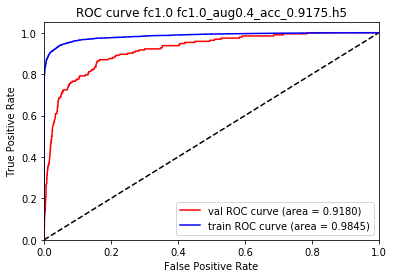

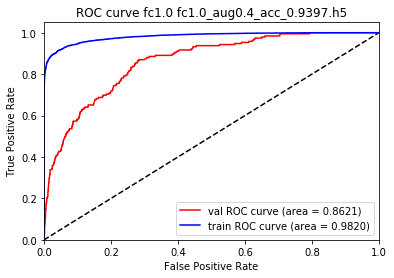

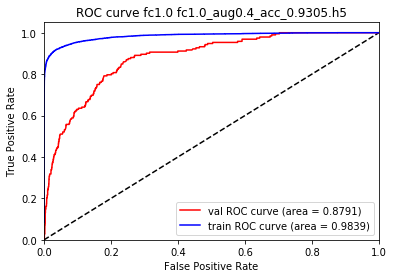

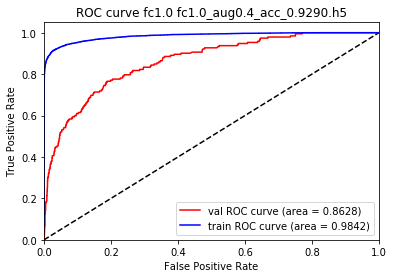

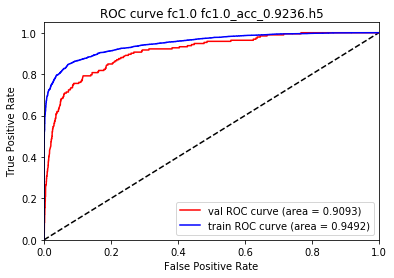

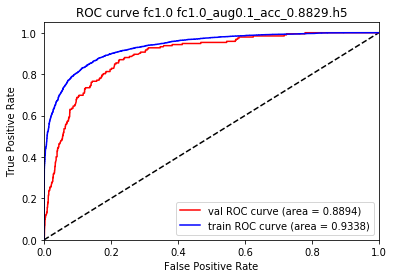

In [198]:
# trained on one set augmentation rate 0.4
model1_3 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_aug0.4_acc_0.9175.h5')
model1_4 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_aug0.4_acc_0.9397.h5')
model1_5 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_aug0.4_acc_0.9305.h5')
model1_1 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_aug0.4_acc_0.9290.h5')

# trained on a number of subsamples
model1_2 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_acc_0.9236.h5')

# trained on one set augmentation rate 0.1
model1_0 = train_utils.plot_fc_results(x_train, y_train, x_val, y_val,'./checkpoints/fc1.0_aug0.1_acc_0.8829.h5')

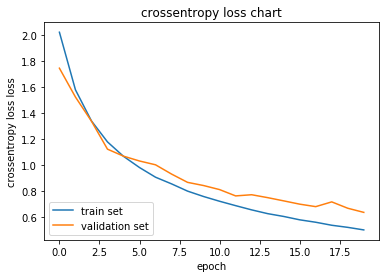

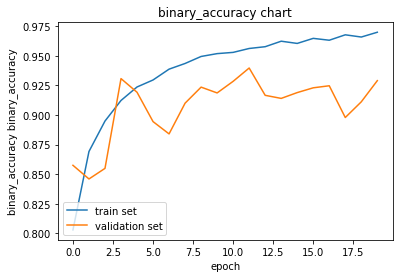

In [51]:
train_utils.plot_loss(history, keys=['loss', 'val_loss'], metric='crossentropy loss')
train_utils.plot_loss(history, keys=['binary_accuracy', 'val_binary_accuracy'], metric='binary_accuracy')

#### Randomized search Random Forest

In [11]:
x_train, x_val, y_train, y_val, state = prep_utils.train_val_data_split(
    x_train_scaled, y_train_df, 0.4, train_df.columns.tolist(), pprint=False)

random_state: 856
after augment train dist - 
50.00%(6677) positive samples, 50.00%(6677) negative samples 


RandomizedSearchCV took 64.57 seconds for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.897 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 19, 'min_impurity_decrease': 0.012}
Model with rank: 2
Mean validation score: 0.891 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 27, 'min_impurity_decrease': 0.012}
Model with rank: 3
Mean validation score: 0.890 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 21, 'min_impurity_decrease': 0.012}


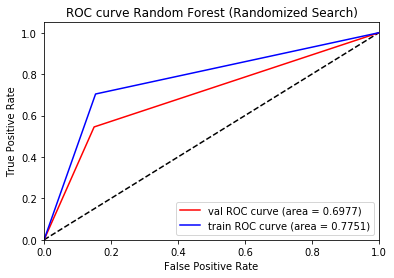

             precision    recall  f1-score   support

          0       0.97      0.85      0.91      3278
          1       0.17      0.54      0.26       189

avg / total       0.93      0.83      0.87      3467



In [12]:
rs_params = {"max_depth": [5, 6, 7],
             "max_features": sp_randint(18, 29),
             'min_impurity_decrease': np.linspace(0.012, 0.042, 7),
             "criterion": ["entropy"]}

# randomized search on all train data (including val set)
rf_clf_rs = train_utils.randomized_search_rf(x_train, x_val, y_train, y_val, rs_params)

train_utils.plot_roc(x_train, y_train, x_val, y_val, rf_clf_rs, 'Random Forest (Randomized Search)')

RandomizedSearchCV took 40.48 seconds for 40 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.888 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 20, 'min_impurity_decrease': 0.002}
Model with rank: 2
Mean validation score: 0.881 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 28, 'min_impurity_decrease': 0.002}
Model with rank: 3
Mean validation score: 0.865 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 26, 'min_impurity_decrease': 0.007714285714285714}


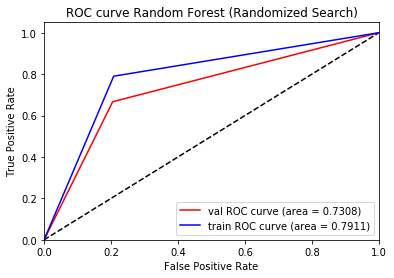

             precision    recall  f1-score   support

          0       0.98      0.79      0.88      3278
          1       0.16      0.67      0.26       189

avg / total       0.93      0.79      0.84      3467



In [14]:
rs_params = {"max_depth": [2, 3, 4],
             "max_features": sp_randint(18, 29),
             'min_impurity_decrease': np.linspace(0.002, 0.042, 8),
             "criterion": ["gini"]}

# randomized search on all train data (including val set)
rf_clf_rs = train_utils.randomized_search_rf(x_train, x_val, y_train, y_val, rs_params)

train_utils.plot_roc(x_train, y_train, x_val, y_val, rf_clf_rs, 'Random Forest (Randomized Search)')

#### Train XGB Random Search

In [159]:
x_train, x_val, y_train, y_val, state = train_val_data_split(x_train_scaled, y_train_df, 0.2, state=0, pprint=False)

random_state: 346
after augment train dist - 
50.00%(6659) positive samples, 50.00%(6659) negative samples 


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   33.1s finished


{'subsample': 0.85, 'min_child_weight': 3.75, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.9}


/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


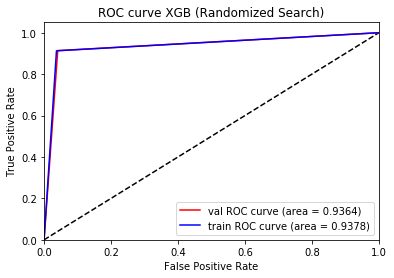

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      3283
          1       0.96      0.91      0.93      3288

avg / total       0.94      0.94      0.94      6571



In [9]:
xgb_params = {
        'min_child_weight': [2.5, 3.75, 5],
        'gamma': [1.75, 2, 2.25],
        'subsample': [0.85, 0.95, 1],
        'colsample_bytree': [0.8, 0.9, 0.95],
        'max_depth': [2, 3, 5]
        }

xgb_rs = train_utils.randomized_search_xgb(x_train, x_val, y_train, y_val, xgb_params)
train_utils.plot_roc(x_train, y_train, x_val, y_val, xgb_rs, 'XGB (Randomized Search)')

#### Train XGB

/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


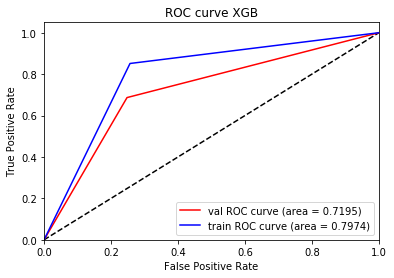

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      3285
          1       0.13      0.69      0.22       182

avg / total       0.93      0.75      0.82      3467



In [131]:
xgb2 = train_utils.train_xgb(x_train, y_train, lr=1e-4, max_depth=5, n_estimators=100)
train_utils.plot_roc(x_train, y_train, x_val, y_val, xgb2, 'XGB')

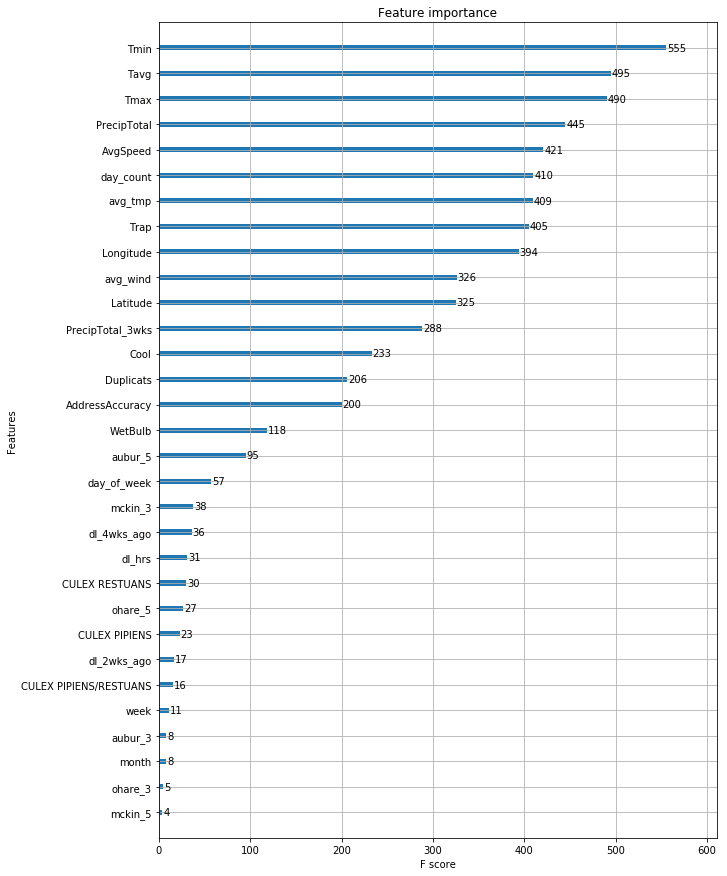

In [10]:
train_utils.plot_xgb_importance(xgb_rs)

#### Collect various model to pd

In [102]:
test_pred_df = train_utils.get_en_pred_df(x_test,
                              [model1_0, model1_1, model1_2, model1_3, model1_4, model1_5, xgb_rs, rf_clf_rs],
                              ['fcnn0', 'fcnn1', 'fcnn2', 'fcnn3', 'fcnn4', 'fcnn5', 'xgbrs', 'rfrs'])

val_pred_df = train_utils.get_en_pred_df(x_val,
                             [model1_0, model1_1, model1_2, model1_3, model1_4, model1_5, xgb_rs, rf_clf_rs],
                              ['fcnn0', 'fcnn1', 'fcnn2', 'fcnn3', 'fcnn4', 'fcnn5', 'xgbrs', 'rfrs'])

/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [11]:
test_pred_df = train_utils.get_en_pred_df(x_test, [xgb_rs], ['xgb_rs'])

val_pred_df = train_utils.get_en_pred_df(x_val,[xgb_rs], ['xgb_rs'])

/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [115]:
test_pred_df = train_utils.get_en_pred_df(x_test,
                              [model1_0, model1_1, best_xgb, rf_clf_rs, clf_dt, clf_rf, clf_et],
                              ['fc1.0', 'fc1.1', 'xgb', 'rfrs', 'dtree', 'rfors', 'extre'])

val_pred_df = train_utils.get_en_pred_df(x_val,
                             [model1_0, model1_1, best_xgb, rf_clf_rs, clf_dt, clf_rf, clf_et],
                              ['fc1.0', 'fc1.1', 'xgb', 'rfrs', 'dtree', 'rfors', 'extre'])

/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/aviavidan/anaconda3/envs/TF/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


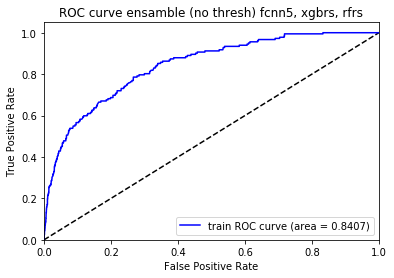

In [106]:
import matplotlib.pyplot as plt
name = 'ensamble (no thresh) fcnn5, xgbrs, rfrs'
val_pred = np.squeeze(val_pred_df['en_avg'])
#val_pred = refine_predict(val_pred, x_val)
fpr, tpr, roc_auc = train_utils.get_fpr_tpr_auc(y_val, val_pred)
train_utils.init_roc_plot()
label = 'train ROC curve (area = %0.4f)' % roc_auc
plt.plot(fpr, tpr, label=label, color='blue') 
plt.title('ROC curve ' + name)
plt.legend(loc="lower right")
plt.show()

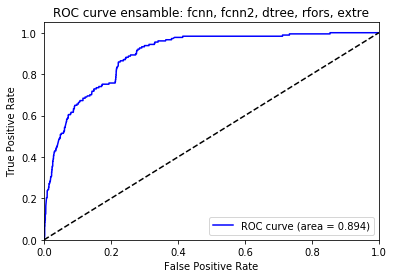

In [179]:
pred_val_en = np.squeeze(val_pred_df['en_avg'])
#pred_val_en = refine_predict(pred_val_en, x_val)

plot_roc(y_val, pred_val_en, 'ensamble: fcnn, fcnn2, dtree, rfors, extre')

#### save for submission

In [12]:
train_utils.save_submission('xgbrs_only_31_feat', test_pred_df['xgb_rs'], x_test)

#### optimize threshold

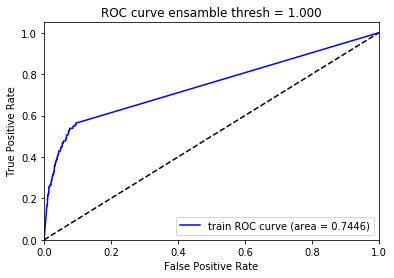

In [124]:
best_auc = 0
for thresh in np.linspace(1.0, 0.05, 96):
    out_val_en = np.copy(val_pred_df['en_avg'])
    out_val_en[val_pred_df['en_avg'] > thresh] = 1
#     out_val_en[val_pred_df['en_avg'] < 0.2] = 0
    out_val_en = np.squeeze(out_val_en).tolist()
    fpr, tpr, roc_auc = train_utils.get_fpr_tpr_auc(y_val, np.squeeze(out_val_en).tolist())
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_thresh = thresh
        bst_val_en = out_val_en
        
name = 'ensamble thresh = {:.3f}'.format(best_thresh)
train_utils.init_roc_plot()
label = 'train ROC curve (area = %0.4f)' % roc_auc
plt.plot(fpr, tpr, label=label, color='blue') 
plt.title('ROC curve ' + name)
plt.legend(loc="lower right")
plt.show()